### 使用CNN 识别手写数字

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, Dataset
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# 选择设备
# GPU usage #########################################
# dtype = torch.FloatTensor # uncomment if you are using CPU
dtype = torch.cuda.FloatTensor # uncomment if you are using GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#### 数据集

In [3]:
batch_size = 64
# 数据集
data_path = './data/MNIST'
trainset = datasets.MNIST(root=data_path,
                        train=True, 
                        download=True, 
                        transform=transforms.ToTensor())

testset = datasets.MNIST(root=data_path, 
                         train=False, 
                         download=True, 
                         transform=transforms.ToTensor())

# 载入数据集
train_data_loader = torch.utils.data.DataLoader(
        dataset=trainset,
        batch_size=batch_size,
        shuffle=True,
        drop_last=True)

test_data_loader = torch.utils.data.DataLoader(
        dataset=testset,
        batch_size=1000,
        shuffle=False,
        drop_last=False)

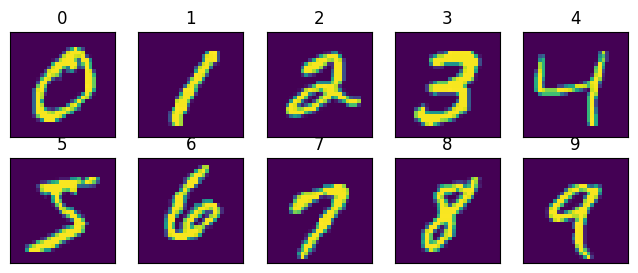

torch.Size([64, 1, 28, 28])
torch.Size([64, 10])
torch.Size([1000, 1, 28, 28])
torch.Size([1000, 10])


In [4]:
# 展示数据集
fig = plt.figure(figsize=(8,3))
num_classes = 10
for i in range(num_classes):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    ax.set_title(f"{i}")
    img = next(img for img, label in trainset if label == i)
    plt.imshow(img.permute(1, 2, 0).numpy())  # permute(1, 2, 0) 将通道维移到最后
plt.show()

images, labels = next(iter(train_data_loader))
print(images.shape)
print(F.one_hot(labels, num_classes=10).shape)

images, labels = next(iter(test_data_loader))
print(images.shape)
print(F.one_hot(labels, num_classes=10).shape)

#### 构建神经网络

In [5]:
# 构建神经网络
class Classifier(nn.Module):
    # Sequential的作用就是连接模型的功能，使代码看起来更加整洁
    def __init__(self, learning_rate):
        super().__init__()
        # 定义网络的结构
        self.model = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Flatten(),
            nn.Linear(32*7*7, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, 10),
        ).to(device)
        
        # 定义损失函数
        self.loss_fun = nn.CrossEntropyLoss()

        # 定义优化器
        # self.optimiser = torch.optim.SGD(self.parameters(), lr=learning_rate) # 随机梯度下降法
        self.optimiser = torch.optim.Adam(self.parameters(), lr=learning_rate) # Adam优化器

        # 记录损失函数
        self.counter = 0 # 训练次数
        self.progress = [] # 损失函数值

    def forward(self, x):
        # 前向传播
        x = self.model(x)
        return x
    
    def NN_train(self, inputs_list, targets_list):
        '''
            训练网络分为两步：
            1、给定训练样本计算输出
            2、将计算得到的输出与设置的标准输出做对比，得到误差函数指导网络权重更新
        '''
        # 前向传播
        outputs = self.model(inputs_list)
        # 计算损失函数
        loss = self.loss_fun(outputs, targets_list)

        # 清空梯度
        self.optimiser.zero_grad()
        # 反向传播
        loss.backward()
        # 更新参数
        self.optimiser.step()

        # 记录损失函数
        self.counter += 1
        # 记录损失函数
        if self.counter%100==0:
            self.progress.append(loss.item())
        

In [6]:
# 实例化网络
lr = 1e-3               # 学习率
epochs = 100    # 设定世代数

In [7]:
CNN =  Classifier(lr)

In [8]:
print("======= 开始训练 =======\n")
for e in range(epochs):
    if e%1==0:    
        print("\r", "学习进度：{:.3f} %".format(e*100/epochs), end='', flush=True)

        for i, data in enumerate(train_data_loader, 0):
            inputs, labels = data
            # 将标签转换为one-hot编码
            # targets = F.one_hot(labels, num_classes=10)
            # 训练网络
            CNN.NN_train(inputs.to(device), labels.to(device))
            # CNN(inputs.to(device))

print("\n======= 训练完成 =======\n")

======= 开始训练 =======

 学习进度：99.000 %
======= 训练完成 =======



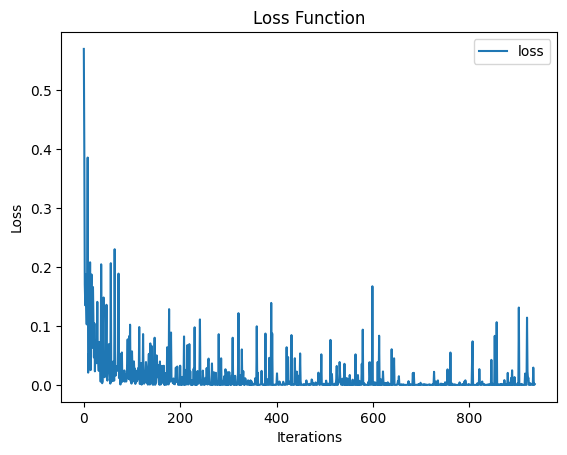

In [9]:
# 画出损失函数
plt.plot(CNN.progress, label='loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Loss Function')
plt.legend()
plt.show()

In [10]:
CNN.eval()
# 测试网络
correct = 0
total = 0
with torch.no_grad():  # 测试时不需要计算梯度
    for data in test_data_loader:
        inputs, labels = data
        labels = labels.to(device)
        outputs = CNN(inputs.to(device))
        _, predicted = torch.max(outputs.data, 1)  # 找到概率最大的下标
        total += labels.size(0)
        correct += (predicted == labels).sum().item()  # 预测正确的数目

print('Accuracy of the network on the 10000 test images: %d %%' % (100 * correct / total))

Accuracy of the network on the 10000 test images: 99 %


In [11]:
# 查看模型参数的概览
print("模型参数概览：")
for name, param in CNN.named_parameters():
    print(f"参数名称: {name}, 形状: {param.shape}")

模型参数概览：
参数名称: model.0.weight, 形状: torch.Size([16, 1, 3, 3])
参数名称: model.0.bias, 形状: torch.Size([16])
参数名称: model.2.weight, 形状: torch.Size([16, 16, 3, 3])
参数名称: model.2.bias, 形状: torch.Size([16])
参数名称: model.5.weight, 形状: torch.Size([32, 16, 3, 3])
参数名称: model.5.bias, 形状: torch.Size([32])
参数名称: model.7.weight, 形状: torch.Size([32, 32, 3, 3])
参数名称: model.7.bias, 形状: torch.Size([32])
参数名称: model.11.weight, 形状: torch.Size([128, 1568])
参数名称: model.11.bias, 形状: torch.Size([128])
参数名称: model.14.weight, 形状: torch.Size([10, 128])
参数名称: model.14.bias, 形状: torch.Size([10])
